# Table of Content

---
* [Import Libraries](#libraries)
* [Upload Dataset from Roboflow](#dataset)
* [Define Path](#path)
* [Visualize Sample Image](#sample-img)
    * [Define Helper Functions](#helper-func)
    * [Apply Functions](#apply-func)
* [K-Fold Cross Validation ](#kfold)
    * [Prepare Dataframe](#kfold-prep-df)
    * [Perform Kfold Cross Validation](#perform-kfold)
* [Model Building](#model-build)
    * [Set Utilities](#utils)
    * [Datasets Preparation](#ds-prep)
    * [Build Model](#model-create)
    * [Set Parameters](#set-params)
    * [Train data without Kfold](#train-no-kfold)
    * [Apply Kfold during training](#train-kfold)
    * [Evaluate Model](#eval)
---

# Import Libraries <a class="anchor" id="libraries"></a>

In [1]:
!pip install torchmetrics[detection]

  Obtaining dependency information for pycocotools>2.0.0 from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 2.9 MB/s eta 0:00:0000:0100:01m


In [2]:
import os
import time
import shutil
from glob import glob
from pathlib import Path
from collections import Counter
from xml.etree import ElementTree as ET
from tqdm.notebook import tqdm
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import torchvision
from torchvision.utils import draw_bounding_boxes
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

# model
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models.detection import (
    SSDLite320_MobileNet_V3_Large_Weights,
    _utils,
    ssdlite320_mobilenet_v3_large,
)
from torchvision.models.detection.ssd import SSDClassificationHead

# metric
from torchmetrics import Precision, Recall
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.0 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Upload Dataset from Roboflow <a class="anchor" id="dataset"></a>

In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("roboflow_api")

In [5]:
# # upload dataset from roboflow 
!pip install roboflow
from roboflow import Roboflow

rf = Roboflow(api_key=secret_value_0)
project = rf.workspace("project-ll4ir").project("ssd_detect_yellow_disease")
dataset = project.version(5).download("voc")

  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/e5/0c/b5a94933f815630171f1ed555ca180325c80d34fc6a42dfb1de4618bfdae/roboflow-1.1.16-py3-none-any.whl.metadata
  Obtaining dependency information for certifi==2023.7.22 from https://files.pythonhosted.org/packages/4c/dd/2234eab22353ffc7d94e8d13177aaa050113286e93e7b40eae01fbf7c3d9/certifi-2023.7.22-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Obtaining dependency information for opencv-python-headless==4.8.0.74 from https://files.pythonhosted.org/packages/76/02/f128517f3ade4bb5f71e2afd8461dba70e3f466ce745fa1fd1fade9ad1b7/opencv_python_headless-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for supervision from https://files.pythonhosted.org/packages/b9/c5/8bb6e9f51e5e8cc9b80fcb5f30a2b7


Extracting Dataset Version Zip to ssd_detect_yellow_disease-5 in voc:: 100%|██████████| 3922/3922 [00:00<00:00, 8659.98it/s]


# Define Path <a class="anchor" id="path"></a>

In [6]:
!rm -rf /kaggle/working/outputs_aug

In [7]:
ROOT = '/kaggle/working'
dataset_path = Path(os.path.join(ROOT, 'ssd_detect_yellow_disease-5'))

train_data_list = sorted(dataset_path.rglob("train/*"))
train_img_path = sorted(dataset_path.rglob("train/*.jpg"))
train_xml_path = sorted(dataset_path.rglob("train/*.xml"))

In [8]:
len(train_img_path)

1568

# Visualize Sample Image <a class="anchor" id="sample-img"></a>

## Define Helper Functions <a class="anchor" id="helper-func"></a>

In [9]:
def img_and_xml(path):
    """
    Match image file and xml file based 
    on their filename to Tuple format
        (image_filepath, annot_filepath)
    """
    # filename = path[:-4]
    filename = path.stem
    dirname = os.path.dirname(path)

    return (
        os.path.join(dirname, f"{filename}.jpg"),
        os.path.join(dirname, f"{filename}.xml"),
    )


def print_xml(xml_path):
    """
    Read XML files and print it
    """
    with open(xml_path, "r", encoding="utf-8") as annot:
        print(" ".join(annot.readlines()))


def get_annot_labels(xml_path, ):
    """
    Extracted XML files as annotation that consist
    of bounding boxes coordinates and label name.
    """
    boxes = []
    labels = []

    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Extracted box coordinates for xml files
    #   and corrected for given image size
    for member in root.findall("object"):
        try:
            # Left corner x-coordinates
            xmin = int(member.find("bndbox").find("xmin").text)
            # Right corner x-coordinates
            xmax = int(member.find("bndbox").find("xmax").text)
            # Left corner y-coordinates
            ymin = int(member.find("bndbox").find("ymin").text)
            # Right corner y-coordinates
            ymax = int(member.find("bndbox").find("ymax").text)
            # Get label name
            label = member.find("name").text

        except:
            continue

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return boxes, labels


def visualize_img_with_bbox(path):
    """
    Visualize sample images with it 
    corresponding bounding box(es).

    """
    img_path, xml_path = img_and_xml(path)

    sample_img = Image.open(img_path)
    sample_annot, sample_label = get_annot_labels(xml_path)

    tensor_img = (transforms.ToTensor()(sample_img) * 255).to(torch.uint8)
    tensor_annot = torch.tensor(sample_annot)

    dict_color = {"positif_begomovirus": "red", "negatif_begomovirus": "blue"}
    colors = [dict_color[x] for x in sample_label]
    img = draw_bounding_boxes(
        tensor_img, boxes=tensor_annot, labels=sample_label, width=3, colors=colors
    )

    img_filename = os.path.basename(img_path)
    annot_filename = os.path.basename(xml_path)
    print(f"image: {img_filename}")
    print(f"annot: {annot_filename}")
    view_img = transforms.ToPILImage()(img)

    return view_img

## Apply Functions <a class="anchor" id="apply-func"></a>

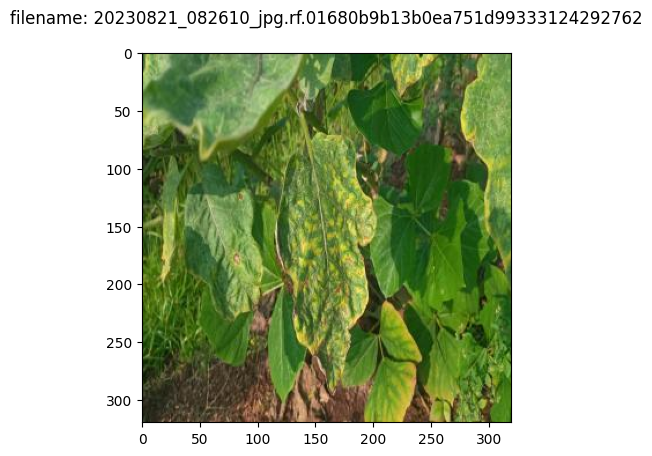

In [10]:
sample = plt.imread(train_img_path[2])

plt.title(f"filename: {train_img_path[2].stem}\n")
plt.imshow(sample)

In [11]:
print_xml(train_xml_path[2])

<annotation>
 	<folder></folder>
 	<filename>20230821_082610_jpg.rf.01680b9b13b0ea751d99333124292762.jpg</filename>
 	<path>20230821_082610_jpg.rf.01680b9b13b0ea751d99333124292762.jpg</path>
 	<source>
 		<database>roboflow.com</database>
 	</source>
 	<size>
 		<width>320</width>
 		<height>320</height>
 		<depth>3</depth>
 	</size>
 	<segmented>0</segmented>
 	<object>
 		<name>positif_begomovirus</name>
 		<pose>Unspecified</pose>
 		<truncated>0</truncated>
 		<difficult>0</difficult>
 		<occluded>0</occluded>
 		<bndbox>
 			<xmin>117</xmin>
 			<xmax>203</xmax>
 			<ymin>66</ymin>
 			<ymax>299</ymax>
 		</bndbox>
 	</object>
 	<object>
 		<name>negatif_begomovirus</name>
 		<pose>Unspecified</pose>
 		<truncated>0</truncated>
 		<difficult>0</difficult>
 		<occluded>0</occluded>
 		<bndbox>
 			<xmin>35</xmin>
 			<xmax>108</xmax>
 			<ymin>92</ymin>
 			<ymax>233</ymax>
 		</bndbox>
 	</object>
 </annotation>



In [12]:
get_annot_labels(train_xml_path[2])

([[117, 66, 203, 299], [35, 92, 108, 233]],
 ['positif_begomovirus', 'negatif_begomovirus'])

image: 20230821_082610_jpg.rf.01680b9b13b0ea751d99333124292762.jpg
annot: 20230821_082610_jpg.rf.01680b9b13b0ea751d99333124292762.xml


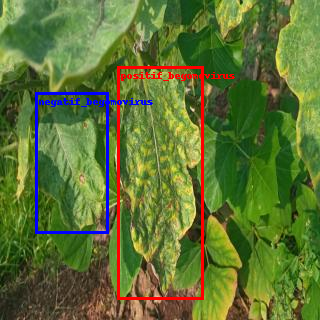

In [13]:
visualize_img_with_bbox(train_data_list[4])

# K-Fold Cross Validation <a class="anchor"  id="kfold"></a>

## Prepare Dataframe <a class="anchor"  id="kfold-prep-df"></a>

In [14]:
class_names = ["negatif_begomovirus", "positif_begomovirus"]

In [15]:
# get data from each dataset split
data_splits = ["train", "valid"]

# Initialize an empty list to store image and label file paths
images = []
labels = []

# Loop through data splits and gather the files
for s in tqdm(data_splits):
    images.extend(sorted(dataset_path.rglob(f"{s}/*.jpg")))
    labels.extend(sorted(dataset_path.rglob(f"{s}/*.xml")))

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
len(images), len(labels)

(1959, 1959)

In [17]:
# initialize empty pandas dataframe
import pandas as pd

indx = [l.stem for l in labels]
labels_df = pd.DataFrame([], columns=class_names, index=indx)

In [18]:
labels_df

,negatif_begomovirus,positif_begomovirus
20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b,NaN,NaN
20230115_101343_jpg.rf.5f9f4e947264c57781ea6f03c32501bb,NaN,NaN
20230821_082610_jpg.rf.01680b9b13b0ea751d99333124292762,NaN,NaN
20230830_135858_jpg.rf.5870cb7d6eda565c5f4d90855882137d,NaN,NaN
20230830_135910_jpg.rf.06385419876038b04d82f57cec115190,NaN,NaN
...,...,...
Screenshot-2023-10-25-122008_png.rf.425c16d5cd42964b6e1712798e97e585,NaN,NaN
Screenshot-2023-10-25-122026_png.rf.fd0c56169238943c26822d47d70336ef,NaN,NaN
Screenshot-2023-10-25-122039_png.rf.d5c4c65345d0c1827261d768f45c4c66,NaN,NaN
Screenshot-2023-10-25-122050_png.rf.b1aee004185f5156343f81cf8928a082,NaN,NaN


In [19]:
# Count the instances of each class-label present in the annotation files
for label in tqdm(labels):
    label_counter = Counter()
    tree = ET.parse(label)
    root = tree.getroot()

    labelname = [member.find("name").text for member in root.findall("object")]

    label_counter.update(labelname)

    # print(label_counter)

    labels_df.loc[label.stem] = label_counter

labels_df = labels_df.fillna(0.0)

  0%|          | 0/1959 [00:00<?, ?it/s]

In [20]:
# sample view of the populated DataFrame
labels_df

,negatif_begomovirus,positif_begomovirus
20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b,0.0,1.0
20230115_101343_jpg.rf.5f9f4e947264c57781ea6f03c32501bb,0.0,1.0
20230821_082610_jpg.rf.01680b9b13b0ea751d99333124292762,1.0,1.0
20230830_135858_jpg.rf.5870cb7d6eda565c5f4d90855882137d,1.0,0.0
20230830_135910_jpg.rf.06385419876038b04d82f57cec115190,2.0,0.0
...,...,...
Screenshot-2023-10-25-122008_png.rf.425c16d5cd42964b6e1712798e97e585,1.0,0.0
Screenshot-2023-10-25-122026_png.rf.fd0c56169238943c26822d47d70336ef,1.0,0.0
Screenshot-2023-10-25-122039_png.rf.d5c4c65345d0c1827261d768f45c4c66,1.0,0.0
Screenshot-2023-10-25-122050_png.rf.b1aee004185f5156343f81cf8928a082,1.0,0.0


<BarContainer object of 2 artists>

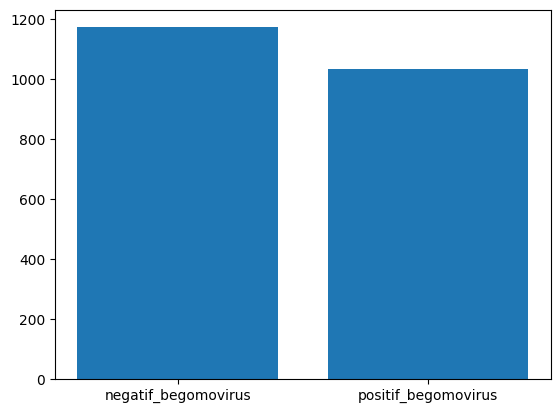

In [21]:
# Visualize the sum of instances of each class-label present in the annotation files
col_sum = labels_df.sum(axis=0)
plt.bar(col_sum.index, col_sum.values)

In [22]:
col_sum.values

array([1174., 1036.])

## Perform Kfold Cross Validation <a class="anchor"  id="perform-kfold"></a>

In [23]:
# initialize K-Fold cross validation with k=5
from sklearn.model_selection import KFold

ksplit = 5
kf = KFold(
    n_splits=ksplit, shuffle=True, random_state=42
)

kfolds = list(kf.split(labels_df))

In [24]:
# separate each split
folds = [f"fold_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

# fill df values with train and val split
for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"fold_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"fold_{idx}"].loc[labels_df.iloc[val].index] = "val"

In [25]:
folds_df

,fold_1,fold_2,fold_3,fold_4,fold_5
20230115_101227_jpg.rf.01e5971785f1519acb15ab40e647897b,train,train,val,train,train
20230115_101343_jpg.rf.5f9f4e947264c57781ea6f03c32501bb,train,train,train,train,val
20230821_082610_jpg.rf.01680b9b13b0ea751d99333124292762,train,val,train,train,train
20230830_135858_jpg.rf.5870cb7d6eda565c5f4d90855882137d,train,train,val,train,train
20230830_135910_jpg.rf.06385419876038b04d82f57cec115190,train,train,train,val,train
...,...,...,...,...,...
Screenshot-2023-10-25-122008_png.rf.425c16d5cd42964b6e1712798e97e585,train,train,val,train,train
Screenshot-2023-10-25-122026_png.rf.fd0c56169238943c26822d47d70336ef,train,train,train,train,val
Screenshot-2023-10-25-122039_png.rf.d5c4c65345d0c1827261d768f45c4c66,train,train,train,val,train
Screenshot-2023-10-25-122050_png.rf.b1aee004185f5156343f81cf8928a082,train,train,train,val,train


In [26]:
# get label distribution in each fold
fold_lbl_distrb = pd.DataFrame(index=folds, columns=class_names)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1e-7)
    fold_lbl_distrb.loc[f"fold_{n}"] = ratio

In [27]:
fold_lbl_distrb

,negatif_begomovirus,positif_begomovirus
fold_1,0.247609,0.266504
fold_2,0.254274,0.266504
fold_3,0.222917,0.263415
fold_4,0.285871,0.213115
fold_5,0.241015,0.242206


In [28]:
# Create the necessary directories
save_path = Path(dataset_path / f"{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)

for split in tqdm(folds_df.columns):
    # Create directories
    fold_dir = save_path / split
    fold_dir.mkdir(parents=True, exist_ok=True)
    (fold_dir / "train").mkdir(parents=True, exist_ok=True)
    (fold_dir / "val").mkdir(parents=True, exist_ok=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
# fill the directories with data according to the structure in folds_df dataframe
for image, label in tqdm(zip(images, labels)):
    for split, fold in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / fold
        lbl_to_path = save_path / split / fold

        # Copy image and label files to new directory
        #   (SamefileError if file already exists)
        shutil.copy(image, img_to_path)
        shutil.copy(label, lbl_to_path)

0it [00:00, ?it/s]

In [30]:
def check_unmatched_filename(k, data_split):
    """
    Check each fold to make sure images in each
    split has its own corresponding annotation.
    """
    kfold_paths = Path(os.path.join(ROOT, 'ssd_detect_yellow_disease-2/5-Fold_Cross-val'))

    # Collect img files and annotation files
    img_files = sorted(kfold_paths.rglob(f"fold_{k}/{data_split}/*.jpg"))
    xml_files = sorted(kfold_paths.rglob(f"fold_{k}/{data_split}/*.xml"))

    unmatched_files = []

    # iterate through images list and find
    #   if there is image without its label
    for img_file in img_files:
        match_xml = img_file.stem + '.xml'
        if match_xml not in xml_files:
            unmatched_files.append(match_xml)

    # iterate through images list and find
    #   if there is label without image
    for xml_file in xml_files:
        match_img = xml_file.stem + '.jpg'
        if match_img not in img_files:
            unmatched_files.append(match_img)

    if unmatched_files:
        print(f"Unmatched files found in fold_{k}:")
        for file in unmatched_files:
            print(file)
    else:
        print("All files have matching counterparts.")

In [31]:
for k in range(1, 6):
    print(f'fold: {k}')
    check_unmatched_filename(k, train)
    check_unmatched_filename(k, val)

fold: 1
All files have matching counterparts.
All files have matching counterparts.
fold: 2
All files have matching counterparts.
All files have matching counterparts.
fold: 3
All files have matching counterparts.
All files have matching counterparts.
fold: 4
All files have matching counterparts.
All files have matching counterparts.
fold: 5
All files have matching counterparts.
All files have matching counterparts.


In [32]:
kfold_paths = Path(os.path.join(ROOT, 'ssd_detect_yellow_disease-5/5-Fold_Cross-val'))
train_files = sorted(kfold_paths.rglob(f"fold_1/train/*.jpg"))
len(train_files)

1567

# Model Building  <a class="anchor"  id="model-build"></a>

## Set Utilities <a class="anchor"  id="utils"></a>

In [33]:
plt.style.use("ggplot")


class Averager:
    """
    keep track of the training and validation loss values
    and helps to get the average for each epochs
    """

    # define initial values and iterations
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


class SaveBestModel:
    """
    Save the best model while training. If the current epoch's
    validation mAP @0.5:0.95 IoU higher than the previous highest,
    then save the model
    """

    def __init__(self, best_valid_map=float(0)):
        self.best_valid_map = best_valid_map

    def __call__(self, model, current_valid_map, epoch, output_dir, k=None):
        if current_valid_map > self.best_valid_map:
            self.best_valid_map = current_valid_map
            print(f"\nBest Validation mAP: {self.best_valid_map}\n")
            print(f"Saving Best Model for Epoch: {epoch + 1}")
            if k:
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                    },
                    f"{output_dir}/fold{k}_best_model.pt",
                )
            else:
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model_state_dict": model.state_dict(),
                    },
                    f"{output_dir}/best_model.pt",
                )

In [34]:
def collate_fn(batch):
    """
    Handle the data loading as different images may 
    have different numbers of objects and to handle
    varying size tensors
    """
    return tuple(zip(*batch))


def get_train_transform():
    """
    Apply transformation for train image data
    """
    return A.ReplayCompose(
        [
            A.Rotate(limit=20, p=0.5),
            A.RandomBrightness(limit=0.15, p=0.5),
#             A.RandomResizedCrop(height=320, width=320, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=0.5),
#             A.Blur(blur_limit=3, p=0.2),
#             A.MotionBlur(blur_limit=3, p=0.2),
#             A.MedianBlur(blur_limit=3, p=0.2),
#             A.ToGray(p=0.3),
#             A.ColorJitter(p=0.3),
#             A.RandomBrightnessContrast(p=0.3),
#             A.RandomCrop(width=250, height=250, p=0.3),
            A.RandomSizedBBoxSafeCrop(height=320, width=320,p=0.5), 
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )


def get_valid_transform():
    """
    Apply transformation for validation/test image data
    """
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )


def save_model(epoch, model, optimizer, output_dir, k=None):
    """
    save the trained model until current epochs
    """
    if k:
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{output_dir}/fold{k}_model.pt",
        )
    else:
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{output_dir}/model.pt",
        )


def save_loss_plot(
    train_loss_list,
    output_dir,
    k=None
):
    """
    save loss graph through epochs
    """
    fig = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = fig.add_subplot()

    ax.plot(train_loss_list, color="tab:blue")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss/train")
    if k:
        fig.savefig(f"{output_dir}/fold{k}_train_loss_fold")
    else:
        fig.savefig(f"{output_dir}/train_loss")


def save_precision_recall(precision, recall, output_dir, k=None):
    """
    Saves precision and recall value graphs through epochs.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), num=1, clear=True)

    # Plot the precision graph on ax1
    ax1.plot(precision, color="tab:blue", label="Precision")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Precision")
    ax1.legend()

    # Plot the recall graph on ax2
    ax2.plot(recall, color="tab:blue", label="recall")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Recall")
    ax2.legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    if k:
        fig.savefig(f"{output_dir}/fold{k}_precision_recall.png")
    else:
        fig.savefig(f"{output_dir}/precision_recall.png")


def save_mAP(mAP_05, mAP_05_095, output_dir, k=None):
    """
    save the mAP@0.5 and mAP@0.5:0.95 through epochs.
    """
    fig = plt.figure(figsize=(10, 7), num=1, clear=True)
    ax = fig.add_subplot()

    ax.plot(mAP_05, color="tab:orange", linestyle="-", label="mAP@0.5")
    ax.plot(mAP_05_095, color="tab:red", linestyle="-", label="mAP@0.5:0.95")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("mAP")
    ax.legend()
    if k:
        fig.savefig(f"{output_dir}/fold{k}_mAP_fold.png")
    else:
        fig.savefig(f"{output_dir}/mAP.png")

        
def save_train_result_csv(output_dir, 
                          train_loss_list, 
                          map_50_list, 
                          map_list, 
                          k=None):
    """
    Save train and validation results to csv file
    """
    df = pd.DataFrame({
        'Epochs': range(1, len(train_loss_list) + 1),
        'train_loss': train_loss_list,
        'map@0.5': map_50_list,
        'map': map_list
    })
    if k:
        csv_path = os.path.join(output_dir, f"fold{k}_train_results.csv")
    else:
        csv_path = os.path.join(output_dir, f"train_results.csv")
    df.to_csv(csv_path, index=False)

## Datasets Preparation <a class="anchor"  id="ds-prep"></a>

In [35]:
# The dataset class.
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        self.image_file_types = ["*.jpg", "*.jpeg", "*.png", "*.ppm", "*.JPG"]
        self.all_image_paths = []

        # get all the image path in sorted order
        for file_type in self.image_file_types:
            if file_type in self.image_file_types:
                self.all_image_paths.extend(
                    glob(os.path.join(self.dir_path, file_type))
                )

        self.all_images = [
            image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths
        ]
        self.all_images = sorted(self.all_images)
    
    def __len__(self):
        # get the size of dataset when call len(dataset)
        return len(self.all_images) 

    def __getitem__(self, idx):
        # get the image name and its full path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # Read and preprocess the image.
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # get corresponding XML file for the annotation
        annot_filename = os.path.splitext(image_name)[0] + ".xml"
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        
        # parse pascal voc format annotation
        tree = ET.parse(annot_file_path)
        root = tree.getroot()

        # original image width and height
        image_width = image.shape[1]
        image_height = image.shape[0]

        # box coordinates for xml files are extracted
        #   and corrected for given image size
        for member in root.findall("object"):
            # get label and map the 'classes'
            labels.append(self.classes.index(member.find("name").text))

            # Left corner x-coordinates.
            xmin = int(member.find("bndbox").find("xmin").text)
            # Right corner x-coordinates.
            xmax = int(member.find("bndbox").find("xmax").text)
            # Left corner y-coordinates.
            ymin = int(member.find("bndbox").find("ymin").text)
            # Right corner y-coordinates.
            ymax = int(member.find("bndbox").find("ymax").text)

            # Resize the bounding boxes according
            #   to resized image 'width' and 'height'
            xmin_final = (xmin / image_width) * self.width
            xmax_final = (xmax / image_width) * self.width
            ymin_final = (ymin / image_height) * self.height
            ymax_final = (ymax / image_height) * self.height

            # check that all coordinates are within the image
            if xmax_final > self.width:
                xmax_final = self.width
            if ymax_final > self.height:
                ymax_final = self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # bounding bo to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # area of bounding box
        area = (
            (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            if len(boxes) > 0
            else torch.as_tensor(boxes, dtype=torch.float32)
        )

        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(
                image=image_resized, bboxes=target["boxes"], labels=labels
            )
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])
            # Normalize bounding boxes
#             target['boxes'] = target['boxes'] / torch.tensor([self.width, self.height, self.width, self.height], dtype=torch.float32)
        
        # checks if any of the bounding box coord contain NaN values or if there are no bounding boxes 
        if np.isnan((target["boxes"]).numpy()).any() or target[
            "boxes"
        ].shape == torch.Size([0]):
            target["boxes"] = torch.zeros((0, 4), dtype=torch.int64)

        return image_resized, target

In [36]:
# prepare the final datasets and data loaders
def create_train_dataset(dir, width, height, classes, transform):
    train_dataset = CustomDataset(
        dir, 
        width, 
        height, 
        classes, 
        transform
    )

    return train_dataset


def create_valid_dataset(dir, width, height, classes, transform):
    valid_dataset = CustomDataset(
        dir, 
        width, 
        height, 
        classes, 
        transform
    )

    return valid_dataset


def create_train_loader(train_dataset, batch_size, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True,
    )

    return train_loader


def create_valid_loader(valid_dataset, batch_size, num_workers=0):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        drop_last=True,
    )

    return valid_loader

## Build Model <a class="anchor"  id="model-create"></a>

In [37]:
def create_model(num_classes, size=320):
    # load torchvision pretrained model
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(
        weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
    )

    # Retrieve the list of input channel
    in_channel = _utils.retrieve_out_channels(model.backbone, (size, size))

    # list containing number of anchors based on aspect ratio
    num_anchors = model.anchor_generator.num_anchors_per_location()

    # classification head
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channel, num_anchors=num_anchors, num_classes=num_classes
    )

    # images size to transform
    model.transform.min_size = (size,)
    model.transform.max_size = size

    # total params and trainable params
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters")

    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    print(f"{total_trainable_params:,} training parameters")

    return model

## Set Training <a class="anchor"  id="set-train"></a>

In [38]:
# running training iteration
def train_step(train_loader, model, train_loss_hist, optimizer):
    """
    Train a pytorch model for a single epoch

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).
    """
    print("Training!")
    model.train()

    # initialize progress bar
    progress_bar = tqdm(train_loader, total=len(train_loader))

    for i, data in enumerate(progress_bar):
        images, targets = data

        # send data to target device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # forward pass
        loss_dict = model(images, targets)

        # calculate and accumulate loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        # zero grad
        optimizer.zero_grad()

        # loss backward
        losses.backward()

        # optimizer step
        optimizer.step()

        # update the loss value beside the progress bar for each iter
        progress_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return loss_value


# running validation iterations
def validate_step(valid_loader, model):
    """
    Validate pytorch model for a single epoch

    Turns a target PyTorch model to "inference" mode and
    then performs a forward pass on a validating dataset.
    """
    print("Validating!")
    model.eval()

    # initialize progress bar
    progress_bar = tqdm(valid_loader, total=len(valid_loader))
    target = []
    preds = []
    
    for i, data in enumerate(progress_bar):
        images, targets = data

        # send data to device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.inference_mode():
            outputs = model(images, targets)

        ## mAP calculation using Torchmetrics
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()

            true_dict["boxes"] = targets[i]["boxes"].detach().cpu()
            true_dict["labels"] = targets[i]["labels"].detach().cpu()
            preds_dict["boxes"] = outputs[i]["boxes"].detach().cpu()
            preds_dict["scores"] = outputs[i]["scores"].detach().cpu()
            preds_dict["labels"] = outputs[i]["labels"].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)

    metric = MeanAveragePrecision(extended_summary=True)
    metric.update(preds, target)
    metric_summary = metric.compute()

    return metric_summary

In [39]:
def train(model, 
          train_loader, 
          valid_loader, 
          optimizer, 
          epochs, 
          scheduler, 
          output_dir,
          k=None):
    """
    Train and test a PyTorch model

    Passed a target model through train_step and validation_stap
    functions for the number of epochs, training and validating
    the model in the same loop.

    """
    # monitor training loss
    train_loss_hist = Averager()

    # store training loss and mAP values
    train_loss_list = []
    map_50_list = []
    map_list = []
    precision_list = []
    recall_list = []

    # name the model
    MODEL_NAME = "model"

    # save best model
    save_best_model = SaveBestModel()

    # train loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1} of {epochs}")

        # reset the training loss histories for the current epoch
        train_loss_hist.reset()

        # start timer and carry out training and validation
        start = time.time()
        train_loss = train_step(train_loader, model, train_loss_hist, optimizer)
        metric_summary = validate_step(valid_loader, model)
        
        # because precision output: a tensor of shape (TxRxKxAxM) 
        # and recall output: a tensor of shape (TxKxAxM)
        # get the average value of tensor to get overall value
        precision_val = metric_summary['precision'].mean()
        recall_val = metric_summary['recall'].mean()

        print(f"Epoch #{epoch+1}")
        print(f"train loss: {train_loss_hist.value:.3f}") 
        print(f"mAP@0.5: {metric_summary['map_50']} | mAP: {metric_summary['map']} | precision: {precision_val} | recall: {recall_val}")

        # end timer and show training duration
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

        # collect train result
        train_loss_list.append(train_loss)
        map_50_list.append(metric_summary["map_50"])
        map_list.append(metric_summary["map"])
        precision_list.append(precision_val)
        recall_list.append(recall_val)

        # save the best model
        if output_dir is None:
            os.makedirs(output_dir, exist_ok=True)

        # add fold to filename if k is not None
        if k:
            save_best_model(model, float(metric_summary["map"]), epoch, output_dir, k=k)
            # save the current epoch model
            save_model(epoch, model, optimizer, output_dir, k=k)
            # save loss plot
            save_loss_plot(train_loss_list, output_dir, k=k)
            # save mAP plot
            save_mAP(map_50_list, map_list, output_dir, k=k)
            # save precision and recall plot
            save_precision_recall(precision_list, recall_list, output_dir, k=k)
        else:
            save_best_model(model, float(metric_summary["map"]), epoch, output_dir)
            # save the current epoch model
            save_model(epoch, model, optimizer, output_dir)
            # save loss plot
            save_loss_plot(train_loss_list, output_dir)
            # save mAP plot
            save_mAP(map_50_list, map_list, output_dir)
            # save precision and recall plot
            save_precision_recall(precision_list, recall_list, output_dir)
            
        scheduler.step()
    
    if k:
        save_train_result_csv(output_dir, train_loss_list, map_50_list, map_list, k=k)
    else:
        save_train_result_csv(output_dir, train_loss_list, map_50_list, map_list)

## Set Parameters <a class="anchor"  id="set-params"></a>

In [40]:
BATCH_SIZE = 32
IMG_SIZE = 320  # according to ssdlite320_mobilenet_v3_large model docs
NUM_EPOCHS = 20
NUM_WORKERS = 4

# use cuda if GPU is available, else use CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# define path without kfold cross val
DATA_PATH = Path(os.path.join(ROOT, "ssd_detect_yellow_disease-5"))
TRAIN_DIR = Path(os.path.join(DATA_PATH, 'train'))
VALID_DIR = Path(os.path.join(DATA_PATH, 'valid'))

# define cross val dataset path
DATA_PATH_KFOLD = Path(os.path.join(DATA_PATH, "5-Fold_Cross-val"))

CLASSES = ["__background__", "negatif_begomovirus", "positif_begomovirus"]

NUM_CLASSES = len(CLASSES)

## Train data without Kfold <a class="anchor"  id="train-no-kfold"></a>

In [41]:
# # using data augmentation
# seed = 42
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

# # location to save training outputs
# OUTPUT_DIR = "outputs_aug"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # initialize the model
# model = create_model(num_classes=NUM_CLASSES, size=IMG_SIZE)
# model = model.to(DEVICE)
# params = [p for p in model.parameters() if p.requires_grad]

# # optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
# OPTIMIZER = torch.optim.Adam(params, lr=1e-3)
# SCHEDULER = StepLR(optimizer=OPTIMIZER, step_size=10, gamma=0.1, verbose=True)

# train_ds = create_train_dataset(dir=TRAIN_DIR,
#                                 width=IMG_SIZE,
#                                 height=IMG_SIZE,
#                                 classes=CLASSES,
#                                 transform=get_train_transform())
# valid_ds = create_valid_dataset(dir=VALID_DIR,
#                                 width=IMG_SIZE,
#                                 height=IMG_SIZE,
#                                 classes=CLASSES,
#                                 transform=get_valid_transform())
# train_loader = create_train_loader(train_ds,
#                                    batch_size=BATCH_SIZE,
#                                    num_workers=NUM_WORKERS)
# valid_loader = create_valid_loader(valid_ds,
#                                    batch_size=BATCH_SIZE,
#                                    num_workers=NUM_WORKERS)

# # train model
# train(model=model,
#       train_loader=train_loader,
#       valid_loader=valid_loader,
#       optimizer=OPTIMIZER,
#       epochs=NUM_EPOCHS,
#       output_dir=OUTPUT_DIR,
#       scheduler=SCHEDULER)

In [42]:
"""
debug AssertionError: 
All bounding boxes should have positive height and width. Found invalid box 
[320.0, 125.96825408935547, 320.0, 165.58731079101562] for target at index 23.
at fold 5
"""

# TRAIN_DIR = os.path.join(DATA_PATH_KFOLD, f'fold_5', 'train')
# VALID_DIR = os.path.join(DATA_PATH_KFOLD, f'fold_5', 'val')

# train_dataset = create_train_dataset(dir=TRAIN_DIR,
#                                      width=IMG_SIZE,
#                                      height=IMG_SIZE,
#                                      classes=CLASSES,
#                                      transform=get_train_transform())
# valid_dataset = create_valid_dataset(dir=VALID_DIR,
#                                      width=IMG_SIZE,
#                                      height=IMG_SIZE,
#                                      classes=CLASSES,
#                                      transform=get_valid_transform())

# image_path = os.path.join(train_dataset.dir_path, train_dataset.all_images[23])
# img_rese = plt.imread(image_path)
# # plt.imshow(img_rese)

# annotation_path = os.path.splitext(image_path)[0] + ".xml"  # Assuming XML format
# tree = ET.parse(annotation_path)
# root = tree.getroot()
# boxes = []
# for member in root.findall("object"):
#     xmin = int(member.find("bndbox").find("xmin").text)
#     ymin = int(member.find("bndbox").find("ymin").text)
#     xmax = int(member.find("bndbox").find("xmax").text)
#     ymax = int(member.find("bndbox").find("ymax").text)
#     boxes.append([xmin, ymin, xmax, ymax])

# for box in boxes:
#     plt.gca().add_patch(plt.Rectangle((box[0], box[1]),
#                                        box[2] - box[0],
#                                        box[3] - box[1],
#                                        fill=False, edgecolor='red', linewidth=2))
# print(image_path)
# plt.imshow(img_rese)

'\ndebug AssertionError: \nAll bounding boxes should have positive height and width. Found invalid box \n[320.0, 125.96825408935547, 320.0, 165.58731079101562] for target at index 23.\nat fold 5\n'

## Apply Kfold during training <a class="anchor"  id="train-kfold"></a>


########################################################################################################################
Train at fold 1
########################################################################################################################



Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 116MB/s] 


2,526,812 total parameters
2,526,812 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.

Number of training samples: 1567
Number of validation samples: 392

Epoch 1 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #1
train loss: 3.125
mAP@0.5: 0.8215450048446655 | mAP: 0.49593695998191833 | precision: 0.2731158026782928 | recall: 0.3334235005328218
Took 0.456 minutes for epoch 1

Best Validation mAP: 0.49593695998191833

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #2
train loss: 1.859
mAP@0.5: 0.8483067750930786 | mAP: 0.5759435892105103 | precision: 0.30701234316338144 | recall: 0.362926774910063
Took 0.420 minutes for epoch 2

Best Validation mAP: 0.5759435892105103

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #3
train loss: 1.548
mAP@0.5: 0.8236322402954102 | mAP: 0.5141686201095581 | precision: 0.2753439125406385 | recall: 0.3404569162628364
Took 0.443 minutes for epoch 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #4
train loss: 1.583
mAP@0.5: 0.8688457608222961 | mAP: 0.6121562123298645 | precision: 0.3361131340334187 | recall: 0.39391028386758664
Took 0.425 minutes for epoch 4

Best Validation mAP: 0.6121562123298645

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #5
train loss: 1.430
mAP@0.5: 0.8708872199058533 | mAP: 0.6027520895004272 | precision: 0.32602265280086135 | recall: 0.384501587179719
Took 0.437 minutes for epoch 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #6
train loss: 1.321
mAP@0.5: 0.8710644245147705 | mAP: 0.6135594248771667 | precision: 0.3351824547070996 | recall: 0.3747959256966077
Took 0.442 minutes for epoch 6

Best Validation mAP: 0.6135594248771667

Saving Best Model for Epoch: 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #7
train loss: 1.203
mAP@0.5: 0.8823279142379761 | mAP: 0.6331912279129028 | precision: 0.3372542437648002 | recall: 0.39574446778994193
Took 0.433 minutes for epoch 7

Best Validation mAP: 0.6331912279129028

Saving Best Model for Epoch: 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #8
train loss: 1.123
mAP@0.5: 0.9029605388641357 | mAP: 0.6677769422531128 | precision: 0.3599490791791913 | recall: 0.40665423028447756
Took 0.437 minutes for epoch 8

Best Validation mAP: 0.6677769422531128

Saving Best Model for Epoch: 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #9
train loss: 1.081
mAP@0.5: 0.884337306022644 | mAP: 0.6706607341766357 | precision: 0.36796983555804236 | recall: 0.41721489623140057
Took 0.441 minutes for epoch 9

Best Validation mAP: 0.6706607341766357

Saving Best Model for Epoch: 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #10
train loss: 1.075
mAP@0.5: 0.8913573622703552 | mAP: 0.6573312878608704 | precision: 0.3521800949848136 | recall: 0.38841898580265555
Took 0.411 minutes for epoch 10
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 11 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #11
train loss: 0.905
mAP@0.5: 0.9094285368919373 | mAP: 0.6927523016929626 | precision: 0.37900635202418764 | recall: 0.41825282849385853
Took 0.426 minutes for epoch 11

Best Validation mAP: 0.6927523016929626

Saving Best Model for Epoch: 11
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 12 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #12
train loss: 0.803
mAP@0.5: 0.9122741222381592 | mAP: 0.6972212791442871 | precision: 0.3865604449132264 | recall: 0.4271285422385464
Took 0.426 minutes for epoch 12

Best Validation mAP: 0.6972212791442871

Saving Best Model for Epoch: 12
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 13 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #13
train loss: 0.748
mAP@0.5: 0.9147635102272034 | mAP: 0.7089582681655884 | precision: 0.39283799782156553 | recall: 0.4313293828875804
Took 0.423 minutes for epoch 13

Best Validation mAP: 0.7089582681655884

Saving Best Model for Epoch: 13
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 14 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #14
train loss: 0.713
mAP@0.5: 0.9157419800758362 | mAP: 0.7081294059753418 | precision: 0.3926001451116859 | recall: 0.4387525872976738
Took 0.426 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 15 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #15
train loss: 0.700
mAP@0.5: 0.9147307872772217 | mAP: 0.7098631262779236 | precision: 0.3916542695702246 | recall: 0.4356013391898073
Took 0.413 minutes for epoch 15

Best Validation mAP: 0.7098631262779236

Saving Best Model for Epoch: 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #16
train loss: 0.644
mAP@0.5: 0.9155892133712769 | mAP: 0.7081443667411804 | precision: 0.390702813165353 | recall: 0.4338141594982378
Took 0.416 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #17
train loss: 0.639
mAP@0.5: 0.9111950993537903 | mAP: 0.7103949189186096 | precision: 0.39555688151848123 | recall: 0.4390351098620128
Took 0.415 minutes for epoch 17

Best Validation mAP: 0.7103949189186096

Saving Best Model for Epoch: 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #18
train loss: 0.639
mAP@0.5: 0.9142867922782898 | mAP: 0.710597038269043 | precision: 0.40120761575881025 | recall: 0.4488003212619208
Took 0.420 minutes for epoch 18

Best Validation mAP: 0.710597038269043

Saving Best Model for Epoch: 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #19
train loss: 0.606
mAP@0.5: 0.9107514023780823 | mAP: 0.7067596912384033 | precision: 0.3942972947166278 | recall: 0.4398317847566757
Took 0.412 minutes for epoch 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #20
train loss: 0.627
mAP@0.5: 0.919319212436676 | mAP: 0.7110304832458496 | precision: 0.3962297024883634 | recall: 0.44328254408867834
Took 0.398 minutes for epoch 20

Best Validation mAP: 0.7110304832458496

Saving Best Model for Epoch: 20
Adjusting learning rate of group 0 to 1.0000e-05.

########################################################################################################################
Train at fold 2
########################################################################################################################

2,526,812 total parameters
2,526,812 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 1 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #1
train loss: 2.984
mAP@0.5: 0.8020963072776794 | mAP: 0.5173969268798828 | precision: 0.2858005782955128 | recall: 0.3378290837874811
Took 0.429 minutes for epoch 1

Best Validation mAP: 0.5173969268798828

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #2
train loss: 1.781
mAP@0.5: 0.8390195965766907 | mAP: 0.5491451621055603 | precision: 0.30010548097316386 | recall: 0.33615337703535814
Took 0.449 minutes for epoch 2

Best Validation mAP: 0.5491451621055603

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #3
train loss: 1.573
mAP@0.5: 0.8391844630241394 | mAP: 0.5824227333068848 | precision: 0.32472526591422074 | recall: 0.387902274062467
Took 0.442 minutes for epoch 3

Best Validation mAP: 0.5824227333068848

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #4
train loss: 1.455
mAP@0.5: 0.8734355568885803 | mAP: 0.613332986831665 | precision: 0.3471190396351396 | recall: 0.387310774315687
Took 0.439 minutes for epoch 4

Best Validation mAP: 0.613332986831665

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #5
train loss: 1.376
mAP@0.5: 0.8702600598335266 | mAP: 0.627132773399353 | precision: 0.3473958665897565 | recall: 0.38942384561237614
Took 0.433 minutes for epoch 5

Best Validation mAP: 0.627132773399353

Saving Best Model for Epoch: 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #6
train loss: 1.228
mAP@0.5: 0.8579962253570557 | mAP: 0.56377774477005 | precision: 0.3104004513380862 | recall: 0.357829355390241
Took 0.437 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #7
train loss: 1.180
mAP@0.5: 0.8768675327301025 | mAP: 0.6351135969161987 | precision: 0.3520894636452297 | recall: 0.4043882715815158
Took 0.441 minutes for epoch 7

Best Validation mAP: 0.6351135969161987

Saving Best Model for Epoch: 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #8
train loss: 1.099
mAP@0.5: 0.8709347248077393 | mAP: 0.6261433959007263 | precision: 0.3522670690680972 | recall: 0.4041897918777115
Took 0.418 minutes for epoch 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #9
train loss: 1.070
mAP@0.5: 0.8708139061927795 | mAP: 0.5932588577270508 | precision: 0.3324208449100192 | recall: 0.38921547837066406
Took 0.437 minutes for epoch 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #10
train loss: 1.071
mAP@0.5: 0.8717909455299377 | mAP: 0.6319402456283569 | precision: 0.34625161305712127 | recall: 0.4057959460864226
Took 0.427 minutes for epoch 10
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 11 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #11
train loss: 0.873
mAP@0.5: 0.8946622610092163 | mAP: 0.6728132367134094 | precision: 0.37563495283833254 | recall: 0.42375293737660225
Took 0.428 minutes for epoch 11

Best Validation mAP: 0.6728132367134094

Saving Best Model for Epoch: 11
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 12 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #12
train loss: 0.766
mAP@0.5: 0.8954557776451111 | mAP: 0.6784451603889465 | precision: 0.3784071829884352 | recall: 0.42785614842066677
Took 0.421 minutes for epoch 12

Best Validation mAP: 0.6784451603889465

Saving Best Model for Epoch: 12
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 13 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #13
train loss: 0.685
mAP@0.5: 0.8964241743087769 | mAP: 0.674290657043457 | precision: 0.3780283865828977 | recall: 0.43066722753336795
Took 0.417 minutes for epoch 13
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 14 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #14
train loss: 0.685
mAP@0.5: 0.8954870104789734 | mAP: 0.6732519865036011 | precision: 0.37538861221180925 | recall: 0.4282855343276262
Took 0.421 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 15 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #15
train loss: 0.624
mAP@0.5: 0.8979849219322205 | mAP: 0.6775752305984497 | precision: 0.3810562982634835 | recall: 0.4321252278854837
Took 0.416 minutes for epoch 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #16
train loss: 0.665
mAP@0.5: 0.8950952887535095 | mAP: 0.6853691339492798 | precision: 0.3878030114277801 | recall: 0.43595779883294733
Took 0.408 minutes for epoch 16

Best Validation mAP: 0.6853691339492798

Saving Best Model for Epoch: 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #17
train loss: 0.657
mAP@0.5: 0.8983533978462219 | mAP: 0.6822212338447571 | precision: 0.3829625930611259 | recall: 0.43296148817848146
Took 0.410 minutes for epoch 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #18
train loss: 0.624
mAP@0.5: 0.8989604711532593 | mAP: 0.6808215379714966 | precision: 0.38386229407403705 | recall: 0.43548491607411016
Took 0.405 minutes for epoch 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #19
train loss: 0.626
mAP@0.5: 0.9024896621704102 | mAP: 0.6785442233085632 | precision: 0.3812594466469997 | recall: 0.43371982675199977
Took 0.405 minutes for epoch 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #20
train loss: 0.592
mAP@0.5: 0.9029746651649475 | mAP: 0.681704580783844 | precision: 0.3851929978192967 | recall: 0.4357497963854929
Took 0.408 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-05.

########################################################################################################################
Train at fold 3
########################################################################################################################

2,526,812 total parameters
2,526,812 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 1 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #1
train loss: 3.059
mAP@0.5: 0.8200664520263672 | mAP: 0.4690728485584259 | precision: 0.0028306703918723054 | recall: 0.07033045160371214
Took 0.427 minutes for epoch 1

Best Validation mAP: 0.4690728485584259

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #2
train loss: 1.861
mAP@0.5: 0.8888794183731079 | mAP: 0.5428525805473328 | precision: 0.049310171835656065 | recall: 0.11227178880091501
Took 0.429 minutes for epoch 2

Best Validation mAP: 0.5428525805473328

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #3
train loss: 1.654
mAP@0.5: 0.879145085811615 | mAP: 0.6254624128341675 | precision: 0.0831484918151398 | recall: 0.15717632848094013
Took 0.432 minutes for epoch 3

Best Validation mAP: 0.6254624128341675

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #4
train loss: 1.442
mAP@0.5: 0.9173742532730103 | mAP: 0.6676216721534729 | precision: 0.11443029735205802 | recall: 0.17571815541374605
Took 0.428 minutes for epoch 4

Best Validation mAP: 0.6676216721534729

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #5
train loss: 1.434
mAP@0.5: 0.9073977470397949 | mAP: 0.6650025844573975 | precision: 0.10970508972193667 | recall: 0.17761890860697493
Took 0.421 minutes for epoch 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #6
train loss: 1.320
mAP@0.5: 0.9101365804672241 | mAP: 0.6378968358039856 | precision: 0.1028722386375667 | recall: 0.16264401306472503
Took 0.423 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #7
train loss: 1.206
mAP@0.5: 0.9081311821937561 | mAP: 0.6474778652191162 | precision: 0.10192906368057535 | recall: 0.1860383188892493
Took 0.425 minutes for epoch 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #8
train loss: 1.122
mAP@0.5: 0.9025977253913879 | mAP: 0.6609711050987244 | precision: 0.10729522118261359 | recall: 0.1764714284202553
Took 0.411 minutes for epoch 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #9
train loss: 1.088
mAP@0.5: 0.9148421287536621 | mAP: 0.5620467662811279 | precision: 0.060607891904165524 | recall: 0.13548753094262803
Took 0.417 minutes for epoch 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #10
train loss: 1.092
mAP@0.5: 0.8427581787109375 | mAP: 0.6056868433952332 | precision: 0.09281411399326225 | recall: 0.17565003519493813
Took 0.424 minutes for epoch 10
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 11 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #11
train loss: 0.917
mAP@0.5: 0.9373705387115479 | mAP: 0.697810709476471 | precision: 0.13770955334198004 | recall: 0.2042134730605604
Took 0.401 minutes for epoch 11

Best Validation mAP: 0.697810709476471

Saving Best Model for Epoch: 11
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 12 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #12
train loss: 0.757
mAP@0.5: 0.9411273002624512 | mAP: 0.707008421421051 | precision: 0.14406284989384074 | recall: 0.2071757453037793
Took 0.419 minutes for epoch 12

Best Validation mAP: 0.707008421421051

Saving Best Model for Epoch: 12
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 13 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #13
train loss: 0.769
mAP@0.5: 0.9396795630455017 | mAP: 0.704367995262146 | precision: 0.13587604338246972 | recall: 0.19888543386824128
Took 0.402 minutes for epoch 13
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 14 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #14
train loss: 0.707
mAP@0.5: 0.942135214805603 | mAP: 0.7067844867706299 | precision: 0.13708516132506182 | recall: 0.20412996104339146
Took 0.411 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 15 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #15
train loss: 0.675
mAP@0.5: 0.9357717633247375 | mAP: 0.7023295164108276 | precision: 0.13667392403748205 | recall: 0.20670226546945802
Took 0.397 minutes for epoch 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #16
train loss: 0.649
mAP@0.5: 0.9391382932662964 | mAP: 0.7020218372344971 | precision: 0.13257534728713857 | recall: 0.2045545808844757
Took 0.396 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #17
train loss: 0.629
mAP@0.5: 0.9380751848220825 | mAP: 0.7091232538223267 | precision: 0.1363857213320357 | recall: 0.205612286588217
Took 0.403 minutes for epoch 17

Best Validation mAP: 0.7091232538223267

Saving Best Model for Epoch: 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #18
train loss: 0.637
mAP@0.5: 0.9407857656478882 | mAP: 0.7090392708778381 | precision: 0.13849507119478205 | recall: 0.2098530723591403
Took 0.393 minutes for epoch 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #19
train loss: 0.609
mAP@0.5: 0.9423185586929321 | mAP: 0.7096680402755737 | precision: 0.13889951148577126 | recall: 0.21755457265975064
Took 0.387 minutes for epoch 19

Best Validation mAP: 0.7096680402755737

Saving Best Model for Epoch: 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #20
train loss: 0.600
mAP@0.5: 0.9422252774238586 | mAP: 0.7094498872756958 | precision: 0.13824938690456182 | recall: 0.20839150017548075
Took 0.390 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-05.

########################################################################################################################
Train at fold 4
########################################################################################################################

2,526,812 total parameters
2,526,812 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 1 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #1
train loss: 3.031
mAP@0.5: 0.8008641004562378 | mAP: 0.4685060679912567 | precision: 0.1521126856110355 | recall: 0.2359918015565555
Took 0.427 minutes for epoch 1

Best Validation mAP: 0.4685060679912567

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #2
train loss: 1.730
mAP@0.5: 0.8782602548599243 | mAP: 0.5435985326766968 | precision: 0.1847236875502321 | recall: 0.24134179157670899
Took 0.424 minutes for epoch 2

Best Validation mAP: 0.5435985326766968

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #3
train loss: 1.592
mAP@0.5: 0.8700752258300781 | mAP: 0.5926865339279175 | precision: 0.21295269225334135 | recall: 0.30034845097698987
Took 0.437 minutes for epoch 3

Best Validation mAP: 0.5926865339279175

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #4
train loss: 1.478
mAP@0.5: 0.871707558631897 | mAP: 0.6081756949424744 | precision: 0.22629789765256145 | recall: 0.2980257514817255
Took 0.442 minutes for epoch 4

Best Validation mAP: 0.6081756949424744

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #5
train loss: 1.351
mAP@0.5: 0.8877648115158081 | mAP: 0.6241668462753296 | precision: 0.23620705714611512 | recall: 0.28979486930544396
Took 0.421 minutes for epoch 5

Best Validation mAP: 0.6241668462753296

Saving Best Model for Epoch: 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #6
train loss: 1.232
mAP@0.5: 0.8708595037460327 | mAP: 0.6004725694656372 | precision: 0.22370682026852726 | recall: 0.28149585234666963
Took 0.414 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #7
train loss: 1.169
mAP@0.5: 0.8924373984336853 | mAP: 0.6264963150024414 | precision: 0.22730354212713685 | recall: 0.2992552035666714
Took 0.422 minutes for epoch 7

Best Validation mAP: 0.6264963150024414

Saving Best Model for Epoch: 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #8
train loss: 1.110
mAP@0.5: 0.8733012080192566 | mAP: 0.5171474814414978 | precision: 0.17665516779622986 | recall: 0.2586089413947098
Took 0.425 minutes for epoch 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #9
train loss: 1.057
mAP@0.5: 0.904072105884552 | mAP: 0.6701126098632812 | precision: 0.25536150226581256 | recall: 0.31142985389855127
Took 0.418 minutes for epoch 9

Best Validation mAP: 0.6701126098632812

Saving Best Model for Epoch: 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #10
train loss: 1.006
mAP@0.5: 0.9136258363723755 | mAP: 0.6688024997711182 | precision: 0.25167563560296025 | recall: 0.3110907831854074
Took 0.425 minutes for epoch 10
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 11 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #11
train loss: 0.868
mAP@0.5: 0.9263296723365784 | mAP: 0.7085940837860107 | precision: 0.27782611194716944 | recall: 0.33322381230722986
Took 0.417 minutes for epoch 11

Best Validation mAP: 0.7085940837860107

Saving Best Model for Epoch: 11
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 12 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #12
train loss: 0.735
mAP@0.5: 0.9268917441368103 | mAP: 0.7102362513542175 | precision: 0.2865710228242246 | recall: 0.33851859006657625
Took 0.411 minutes for epoch 12

Best Validation mAP: 0.7102362513542175

Saving Best Model for Epoch: 12
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 13 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #13
train loss: 0.674
mAP@0.5: 0.9276888966560364 | mAP: 0.7114912867546082 | precision: 0.28225867530267323 | recall: 0.3377784022999307
Took 0.405 minutes for epoch 13

Best Validation mAP: 0.7114912867546082

Saving Best Model for Epoch: 13
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 14 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #14
train loss: 0.654
mAP@0.5: 0.9316014051437378 | mAP: 0.7120738625526428 | precision: 0.28330612125155374 | recall: 0.34057982037498385
Took 0.415 minutes for epoch 14

Best Validation mAP: 0.7120738625526428

Saving Best Model for Epoch: 14
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 15 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #15
train loss: 0.650
mAP@0.5: 0.9306502342224121 | mAP: 0.7125898599624634 | precision: 0.2873260897614761 | recall: 0.3417988842334562
Took 0.411 minutes for epoch 15

Best Validation mAP: 0.7125898599624634

Saving Best Model for Epoch: 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #16
train loss: 0.696
mAP@0.5: 0.9250381588935852 | mAP: 0.7063477635383606 | precision: 0.28338913760956885 | recall: 0.33808744548932446
Took 0.406 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #17
train loss: 0.665
mAP@0.5: 0.926028311252594 | mAP: 0.7060628533363342 | precision: 0.2793990017141217 | recall: 0.33990033472781195
Took 0.404 minutes for epoch 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #18
train loss: 0.601
mAP@0.5: 0.9284263253211975 | mAP: 0.7092974185943604 | precision: 0.28040593610821496 | recall: 0.34029315761258805
Took 0.391 minutes for epoch 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #19
train loss: 0.575
mAP@0.5: 0.9288821220397949 | mAP: 0.7126577496528625 | precision: 0.28313723391843726 | recall: 0.3444366910349384
Took 0.399 minutes for epoch 19

Best Validation mAP: 0.7126577496528625

Saving Best Model for Epoch: 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/48 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #20
train loss: 0.590
mAP@0.5: 0.9250575304031372 | mAP: 0.7049842476844788 | precision: 0.2896020923487702 | recall: 0.3485461564425164
Took 0.389 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-05.

########################################################################################################################
Train at fold 5
########################################################################################################################

2,526,812 total parameters
2,526,812 training parameters
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 1 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #1
train loss: 3.030
mAP@0.5: 0.7686954736709595 | mAP: 0.46275725960731506 | precision: 0.01025478724929349 | recall: 0.09192304156239366
Took 0.427 minutes for epoch 1

Best Validation mAP: 0.46275725960731506

Saving Best Model for Epoch: 1
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 2 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #2
train loss: 1.820
mAP@0.5: 0.8695271015167236 | mAP: 0.5798176527023315 | precision: 0.07743393837253544 | recall: 0.13723172740475045
Took 0.433 minutes for epoch 2

Best Validation mAP: 0.5798176527023315

Saving Best Model for Epoch: 2
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 3 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #3
train loss: 1.637
mAP@0.5: 0.895499050617218 | mAP: 0.642967939376831 | precision: 0.10807916267397705 | recall: 0.15929819824037764
Took 0.434 minutes for epoch 3

Best Validation mAP: 0.642967939376831

Saving Best Model for Epoch: 3
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 4 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #4
train loss: 1.429
mAP@0.5: 0.9151835441589355 | mAP: 0.6770077347755432 | precision: 0.1275159011771792 | recall: 0.1877141829694903
Took 0.435 minutes for epoch 4

Best Validation mAP: 0.6770077347755432

Saving Best Model for Epoch: 4
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 5 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #5
train loss: 1.350
mAP@0.5: 0.8827293515205383 | mAP: 0.6387947797775269 | precision: 0.09763214881704897 | recall: 0.15336776618841205
Took 0.435 minutes for epoch 5
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 6 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #6
train loss: 1.258
mAP@0.5: 0.8975388407707214 | mAP: 0.6067665219306946 | precision: 0.07919527981101687 | recall: 0.14941866429299897
Took 0.435 minutes for epoch 6
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 7 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #7
train loss: 1.226
mAP@0.5: 0.8994298577308655 | mAP: 0.6543385982513428 | precision: 0.10980809797543645 | recall: 0.164128728198848
Took 0.434 minutes for epoch 7
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 8 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #8
train loss: 1.183
mAP@0.5: 0.8976910710334778 | mAP: 0.6510112285614014 | precision: 0.10423990706190196 | recall: 0.15930439365842847
Took 0.436 minutes for epoch 8
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 9 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #9
train loss: 1.104
mAP@0.5: 0.9181831479072571 | mAP: 0.6770379543304443 | precision: 0.12823739040008794 | recall: 0.1841615449579592
Took 0.433 minutes for epoch 9

Best Validation mAP: 0.6770379543304443

Saving Best Model for Epoch: 9
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch 10 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #10
train loss: 1.022
mAP@0.5: 0.9200219511985779 | mAP: 0.6956679224967957 | precision: 0.1284058713624048 | recall: 0.19035918700251545
Took 0.418 minutes for epoch 10

Best Validation mAP: 0.6956679224967957

Saving Best Model for Epoch: 10
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 11 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #11
train loss: 0.831
mAP@0.5: 0.929806649684906 | mAP: 0.7249523401260376 | precision: 0.15634526573600468 | recall: 0.20282980957531638
Took 0.424 minutes for epoch 11

Best Validation mAP: 0.7249523401260376

Saving Best Model for Epoch: 11
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 12 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #12
train loss: 0.711
mAP@0.5: 0.9344642758369446 | mAP: 0.717276930809021 | precision: 0.1571166558230147 | recall: 0.20580664304276633
Took 0.418 minutes for epoch 12
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 13 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #13
train loss: 0.721
mAP@0.5: 0.9335768818855286 | mAP: 0.7258192896842957 | precision: 0.1603203316995884 | recall: 0.21003930386761774
Took 0.415 minutes for epoch 13

Best Validation mAP: 0.7258192896842957

Saving Best Model for Epoch: 13
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 14 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #14
train loss: 0.679
mAP@0.5: 0.9318674802780151 | mAP: 0.7235544919967651 | precision: 0.15761871899777213 | recall: 0.2064352764098533
Took 0.415 minutes for epoch 14
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 15 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #15
train loss: 0.681
mAP@0.5: 0.9343763589859009 | mAP: 0.7273470759391785 | precision: 0.15628085592504984 | recall: 0.20683877312184512
Took 0.406 minutes for epoch 15

Best Validation mAP: 0.7273470759391785

Saving Best Model for Epoch: 15
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 16 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #16
train loss: 0.624
mAP@0.5: 0.9300844073295593 | mAP: 0.7231884002685547 | precision: 0.1518043453590946 | recall: 0.2074451018814192
Took 0.400 minutes for epoch 16
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 17 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #17
train loss: 0.611
mAP@0.5: 0.9338892698287964 | mAP: 0.7277688980102539 | precision: 0.15752368263298291 | recall: 0.2108294841221956
Took 0.404 minutes for epoch 17

Best Validation mAP: 0.7277688980102539

Saving Best Model for Epoch: 17
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 18 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #18
train loss: 0.613
mAP@0.5: 0.9305853843688965 | mAP: 0.731289803981781 | precision: 0.16076221109537117 | recall: 0.2121199238404543
Took 0.407 minutes for epoch 18

Best Validation mAP: 0.731289803981781

Saving Best Model for Epoch: 18
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 19 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #19
train loss: 0.604
mAP@0.5: 0.933121383190155 | mAP: 0.7231619954109192 | precision: 0.15217186103624195 | recall: 0.20530628312539584
Took 0.406 minutes for epoch 19
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch 20 of 20
Training!


  0%|          | 0/49 [00:00<?, ?it/s]

Validating!


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch #20
train loss: 0.575
mAP@0.5: 0.9351226091384888 | mAP: 0.7236455082893372 | precision: 0.15512983793003343 | recall: 0.2096155387392716
Took 0.390 minutes for epoch 20
Adjusting learning rate of group 0 to 1.0000e-05.


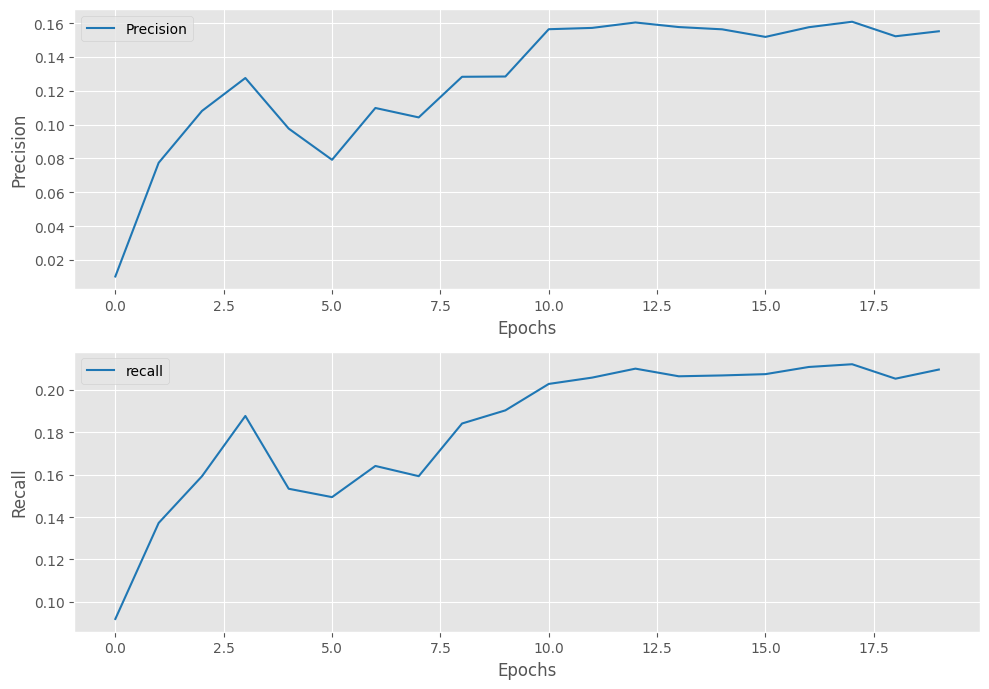

In [43]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# location to save training outputs
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for k in range(1, ksplit+1):
    print('')
    print('#'*120)
    print(f'Train at fold {k}')
    print('#'*120)
    TRAIN_DIR = os.path.join(DATA_PATH_KFOLD, f'fold_{k}', 'train')
    VALID_DIR = os.path.join(DATA_PATH_KFOLD, f'fold_{k}', 'val')

    train_dataset = create_train_dataset(dir=TRAIN_DIR,
                                         width=IMG_SIZE,
                                         height=IMG_SIZE,
                                         classes=CLASSES,
                                         transform=get_train_transform())
    valid_dataset = create_valid_dataset(dir=VALID_DIR,
                                         width=IMG_SIZE,
                                         height=IMG_SIZE,
                                         classes=CLASSES,
                                         transform=get_valid_transform())
    train_loader = create_train_loader(train_dataset,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS)
    valid_loader = create_valid_loader(valid_dataset,
                                       batch_size=BATCH_SIZE,
                                       num_workers=NUM_WORKERS)
    
    # initialize the model
    print('')
    model = create_model(num_classes=NUM_CLASSES, size=IMG_SIZE)
    model = model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]

    # optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
    OPTIMIZER = torch.optim.Adam(params, lr=1e-3)
    SCHEDULER = StepLR(optimizer=OPTIMIZER, step_size=10, gamma=0.1, verbose=True)
    
    # show model architecture only once
    if k == 1:
        print(f"\nNumber of training samples: {len(train_dataset)}")
        print(f"Number of validation samples: {len(valid_dataset)}")
#         print(model)

    # train model
    train(model=model,
          train_loader=train_loader,
          valid_loader=valid_loader,
          optimizer=OPTIMIZER,
          epochs=NUM_EPOCHS,
          scheduler=SCHEDULER,
          output_dir=OUTPUT_DIR,
          k=k)

In [44]:
!zip -r kfold-results2.zip /kaggle/working/outputs

  adding: kaggle/working/outputs/ (stored 0%)
  adding: kaggle/working/outputs/fold2_train_results.csv (deflated 61%)
  adding: kaggle/working/outputs/fold3_precision_recall.png (deflated 11%)
  adding: kaggle/working/outputs/fold3_train_results.csv (deflated 61%)
  adding: kaggle/working/outputs/fold5_mAP_fold.png (deflated 11%)
  adding: kaggle/working/outputs/fold4_train_loss_fold.png (deflated 8%)
  adding: kaggle/working/outputs/fold4_precision_recall.png (deflated 10%)
  adding: kaggle/working/outputs/fold1_model.pt (deflated 10%)
  adding: kaggle/working/outputs/fold5_train_results.csv (deflated 62%)
  adding: kaggle/working/outputs/fold1_train_loss_fold.png (deflated 11%)
  adding: kaggle/working/outputs/fold4_mAP_fold.png (deflated 11%)
  adding: kaggle/working/outputs/fold5_precision_recall.png (deflated 10%)
  adding: kaggle/working/outputs/fold3_model.pt (deflated 10%)
  adding: kaggle/working/outputs/fold4_model.pt (deflated 10%)
  adding: kaggle/working/outputs/fold1_best

In [45]:
from IPython.display import FileLink

FileLink(r'kfold-results2.zip')

/kaggle/working/kfold-results2.zip

## Evaluate Model <a class="anchor"  id="eval"></a>

In [46]:
THRESHOLD = 0.5
COLORS = [[0,0,0], [0,0,255], [255,0,0]]

results_dir = Path(os.path.join(ROOT, 'outputs'))
csv_files = sorted(results_dir.rglob("*.csv"))
csv_files

[PosixPath('/kaggle/working/outputs/fold1_train_results.csv'),
 PosixPath('/kaggle/working/outputs/fold2_train_results.csv'),
 PosixPath('/kaggle/working/outputs/fold3_train_results.csv'),
 PosixPath('/kaggle/working/outputs/fold4_train_results.csv'),
 PosixPath('/kaggle/working/outputs/fold5_train_results.csv')]

In [47]:
# Check results from each fold
res1 = pd.read_csv(csv_files[0]).sort_values(by='map', ascending=False).reset_index(drop=True).loc[[0], ]
res2 = pd.read_csv(csv_files[1]).sort_values(by='map', ascending=False).reset_index(drop=True).loc[[0], ]
res3 = pd.read_csv(csv_files[2]).sort_values(by='map', ascending=False).reset_index(drop=True).loc[[0], ]
res4 = pd.read_csv(csv_files[3]).sort_values(by='map', ascending=False).reset_index(drop=True).loc[[0], ]
res5 = pd.read_csv(csv_files[4]).sort_values(by='map', ascending=False).reset_index(drop=True).loc[[0], ]

In [48]:
all_result = pd.concat([res1, res2, res3, res4, res5], axis=0).assign(fold=range(1, ksplit+1))
all_result

,Epochs,train_loss,map@0.5,map,fold
0,20,0.575215,tensor(0.9193),tensor(0.7110),1
0,16,0.496544,tensor(0.8951),tensor(0.6854),2
0,19,0.980648,tensor(0.9423),tensor(0.7097),3
0,19,0.529716,tensor(0.9289),tensor(0.7127),4
0,18,0.426004,tensor(0.9306),tensor(0.7313),5


In [49]:
all_result.sort_values(by='map', ascending=False)

,Epochs,train_loss,map@0.5,map,fold
0,18,0.426004,tensor(0.9306),tensor(0.7313),5
0,19,0.529716,tensor(0.9289),tensor(0.7127),4
0,20,0.575215,tensor(0.9193),tensor(0.7110),1
0,19,0.980648,tensor(0.9423),tensor(0.7097),3
0,16,0.496544,tensor(0.8951),tensor(0.6854),2


In [50]:
# load the best model and trained weights
model = create_model(num_classes=NUM_CLASSES, size=IMG_SIZE)
checkpoint = torch.load(os.path.join(ROOT, 'outputs', 'fold5_best_model.pt'), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

2,526,812 total parameters
2,526,812 training parameters


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [51]:
VALID_DIR = os.path.join(DATA_PATH_KFOLD, f'fold_5', 'val')
# VALID_DIR = '/kaggle/working/ssd_detect_yellow_disease-5/valid'
valid_img_path = glob(f'{VALID_DIR}/*.jpg')
print(f'Validation Instance: {len(valid_img_path)}')

Validation Instance: 391


In [52]:
def model_inference(threshold=0.5):
    frame_count = 0
    total_fps = 0

    for i in range(len(valid_img_path)):
        img_name = valid_img_path[i].split(os.path.sep)[-1]
        # print(img_name)
        img = cv2.imread(valid_img_path[i])
        original_img = img.copy()
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /=255
        # change image shape structure (H, C, W) => (C, H, W)
        img_input = np.transpose(img, (2,0,1)).astype(np.float32)
        # convert to tensor
        img_input = torch.tensor(img_input, dtype=torch.float).cuda()
        # add batch dims
        img_input = torch.unsqueeze(img_input, 0)

        start_time = time.time()

        # predictions
        with torch.inference_mode():
            outputs = model(img_input.to(DEVICE))

        end_time = time.time()

        # get the current fps
        fps = 1 / (end_time - start_time)
        total_fps += fps
        frame_count += 1

        # load all detections to CPU
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

        # show bbox only if there are detected boxes
        if len(outputs[0]['boxes']) != 0:
            boxes = outputs[0]['boxes'].data.numpy()
            scores = outputs[0]['scores'].data.numpy()

            # filter out boxes according to threshold
            boxes = boxes[scores >= threshold].astype(np.int32)
            draw_boxes = boxes.copy()

            # get all the predicted class names
            pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

            # draw the bounding boxes and write the class name on top of it
            for j, box in enumerate(draw_boxes):
                class_names = pred_classes[j]
                print(class_names)
                color = COLORS[CLASSES.index(class_names)]

                # rescale boxes
                xmin = int((box[0] / img.shape[1]) * original_img.shape[1])
                ymin = int((box[1] / img.shape[0]) * original_img.shape[0])
                xmax = int((box[2] / img.shape[1]) * original_img.shape[1])
                ymax = int((box[3] / img.shape[0]) * original_img.shape[0])

                cv2.rectangle(
                    original_img,
                    (xmin, ymin),
                    (xmax, ymax),
                    color[::-1],
                    3
                )
                cv2.putText(
                    original_img,
                    class_names,
                    (xmin, ymin-5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    color[::-1],
                    2,
                    lineType=cv2.LINE_AA
                )

#             plt.imshow(original_img)
#             cv2.waitKey(1)
            cv2.imwrite(os.path.join(ROOT, 'inference_outputs', 'images', img_name+'.jpg'), original_img)
        print(f'Image {i+1} done...')

    print('Predictions Complete')
#     cv2.destroyAllWindows()
    avg_fps = total_fps / frame_count
    print(f'Average FPS: {avg_fps:.3f}')

In [92]:
# # !pip uninstall opencv-python -y 
# # !pip uninstall opencv-contrib-python -y 

# !pip install opencv-python --upgrade
# # !pip list | grep opencv

In [53]:
os.makedirs(os.path.join(ROOT, 'inference_outputs', 'images'), exist_ok=True)
model_inference(threshold=0.5)

(320, 320, 3)
negatif_begomovirus
Image 1 done...
(320, 320, 3)
negatif_begomovirus
positif_begomovirus
Image 2 done...
(320, 320, 3)
positif_begomovirus
Image 3 done...
(320, 320, 3)
positif_begomovirus
Image 4 done...
(320, 320, 3)
negatif_begomovirus
Image 5 done...
(320, 320, 3)
positif_begomovirus
Image 6 done...
(320, 320, 3)
positif_begomovirus
Image 7 done...
(320, 320, 3)
negatif_begomovirus
Image 8 done...
(320, 320, 3)
negatif_begomovirus
Image 9 done...
(320, 320, 3)
negatif_begomovirus
Image 10 done...
(320, 320, 3)
positif_begomovirus
Image 11 done...
(320, 320, 3)
negatif_begomovirus
Image 12 done...
(320, 320, 3)
negatif_begomovirus
Image 13 done...
(320, 320, 3)
negatif_begomovirus
Image 14 done...
(320, 320, 3)
positif_begomovirus
Image 15 done...
(320, 320, 3)
positif_begomovirus
Image 16 done...
(320, 320, 3)
negatif_begomovirus
Image 17 done...
(320, 320, 3)
negatif_begomovirus
Image 18 done...
(320, 320, 3)
negatif_begomovirus
Image 19 done...
(320, 320, 3)
negati

In [102]:
# !rm /kaggle/working/inference_outputs/output-images.zip

In [56]:
# !zip -r output-images2.zip /kaggle/working/inference_outputs

In [55]:
from IPython.display import FileLink

FileLink(r'output-images2.zip')

/kaggle/working/output-images2.zip